In [80]:
import numpy as np
import matplotlib.pyplot as plt
from config import Conf
import os

In [155]:
%load_ext autoreload
%autoreload 2

import numpy as np
from config import Conf
from curriculum import DataCurriculum
from logger import LearningLogger
import torch

Conf.batch_size = 504
Conf.reward_prob = 1.0
Conf.n_reversals = 1000000
n_trials = 100
Conf.sample = False
# Conf.max_trials_since_reversal = 1
# Conf.jitter = 0

data_curriculum = DataCurriculum(Conf, eval=True)
print(data_curriculum.config.output_dim)
logger = LearningLogger(Conf)
bayes_probs = []

next_input, next_target, ground_truth = data_curriculum.step()
# bayes_probs.append(data_curriculum.optimal_agent.p_A_high)

for i in range(n_trials):
    next_input, next_target, ground_truth = data_curriculum.step(ground_truth=ground_truth)
    
    # Convert data to tensors
    data_tensor = torch.tensor(next_input, dtype=Conf.dtype, device=Conf.dev)
    target_tensor = torch.tensor(next_target, dtype=Conf.dtype, device=Conf.dev)

    p_A = data_curriculum.optimal_agent.p_A_high
    bayes_probs.append(p_A)
    
    logger.log(None, target_tensor.cpu().detach(), data_tensor.cpu().detach(), ground_truth, p_A, np.zeros_like(p_A))

bayes_probs = np.concatenate(bayes_probs, axis=-1)
logger.get_data()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
21


ValueError: all input arrays must have the same shape

In [146]:
import matplotlib.pyplot as plt

print(bayes_probs.shape)
n_p_bins = 200
bin_edges = np.linspace(0, 1, n_p_bins+1)  # Creates 5 edges for 4 bins
print(bin_edges)
bins = np.digitize(bayes_probs, bin_edges[:-1]) - 1
print(bins)
bin_counts = np.bincount(bins.flatten(), minlength=n_p_bins)

plt.bar(bin_edges[:-1], bin_counts, width=np.diff(bin_edges), align='edge', capsize=2)
plt.xlim([0,1])
plt.xlabel('p(A)')
plt.ylabel('count')

AttributeError: 'list' object has no attribute 'shape'

In [147]:
inputs, targets, ground_truth, p_A, accs = logger.inputs_hist, logger.targets_hist, logger.ground_truth_hist, logger.p_A_hist, logger.a_accuracy_steps

print(p_A.shape)

AttributeError: 'LearningLogger' object has no attribute 'inputs_hist'

0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0


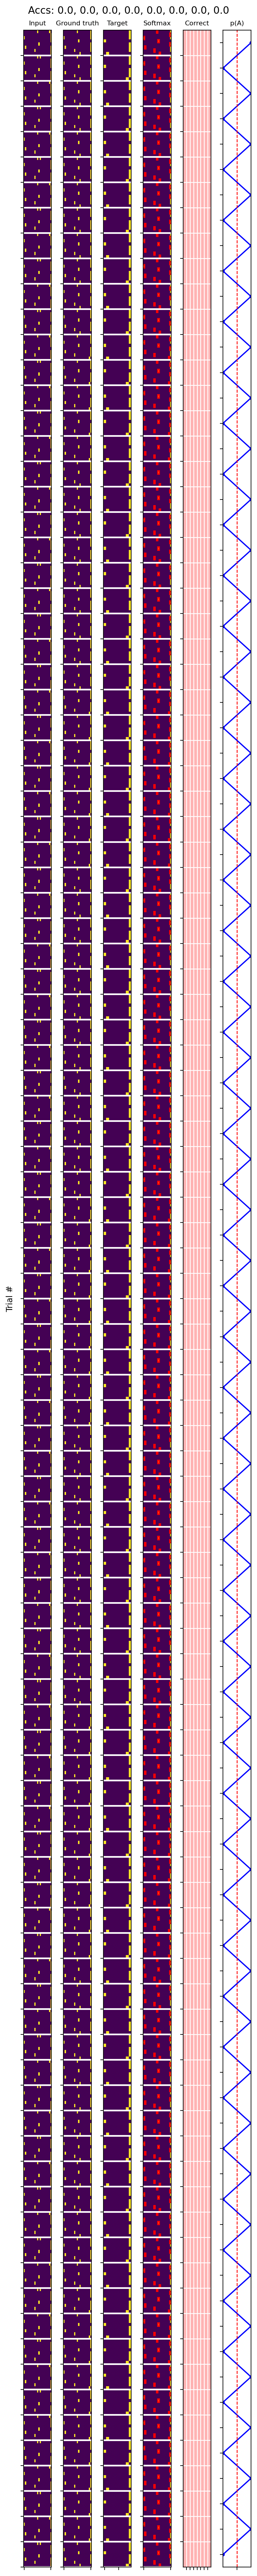

In [148]:
from plotting import *
plot_trials(inputs, ground_truth, targets, ground_truth, p_A=p_A, fname=f'panel_{i}_h5.png', trials=100, b=6)

ValueError: x and y must have same first dimension, but have shapes (1,) and (100,)

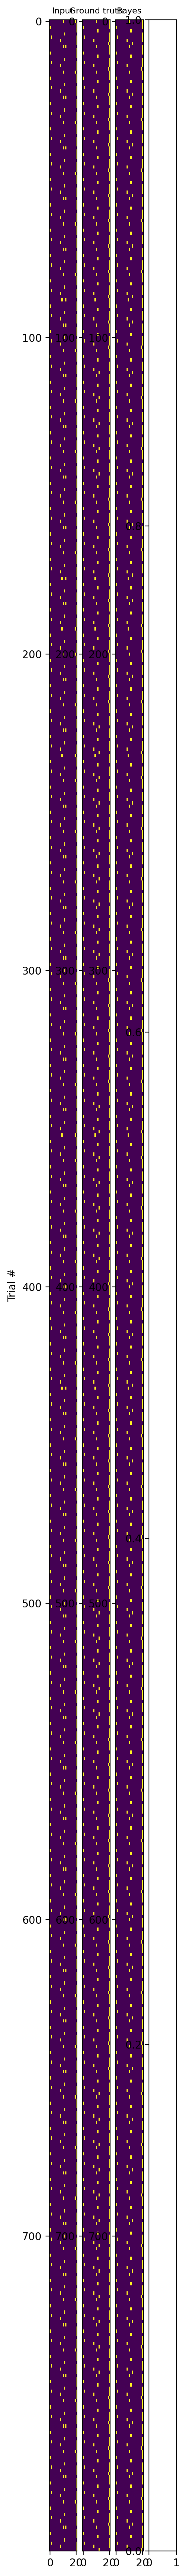

In [124]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

inputs, targets, ground_truth, accs = logger.inputs_hist, logger.targets_hist, logger.ground_truth_hist, logger.a_accuracy_steps

b = 6
trials = 100
t = Conf.trial_len * trials
sf = 1.1

fig, axes = plt.subplots(1,4, figsize=(sf*2, sf*t//20), dpi=200)
axes[0].imshow(inputs[b, :t, :], vmin=0, vmax=1, aspect='auto')
axes[0].set_title('Input', fontsize=8)
axes[0].set_ylabel('Trial #')
axes[1].imshow(ground_truth[b, :t, :], vmin=0, vmax=1, aspect='auto')
axes[1].set_title('Ground truth', fontsize=8)
axes[2].imshow(targets[b, :t, :], vmin=0, vmax=1, aspect='auto')
axes[2].set_title('Bayes', fontsize=8)
axes[3].plot(p_A[b, :trials], 0.5 + np.arange(trials), marker='o', markersize=3, color='b')
axes[3].set_ylim([0, trials])
axes[3].set_xlim([0, 1])
axes[3].invert_yaxis()
axes[3].axvline(x=0.5, color='red', linestyle='--', linewidth=1)
axes[3].set_title('p(A)', fontsize=8)

# Set yticks at every 4th row and enable gridlines only for those ticks
for i, ax in enumerate(axes):
    start, gap, rows = Conf.trial_len-0.5, Conf.trial_len, t
    ax.xaxis.grid(False)
    # Generate ytick locations, starting from 3.5 (since we want lines between blocks of 4)
    yticks = np.arange(start, rows, gap)
    ax.set_yticks(yticks)

    # Enable grid only for y-axis
    ax.yaxis.grid(True, linestyle='-', color='white', linewidth=2)

for ax in axes:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

plt.tight_layout(rect=[0, 0, 1, 0.985]) # Adjust layout to make space for suptitle
plt.show()

fig.savefig(os.path.join(Conf.save_dir, 'panel.png'))


In [43]:
from bayes import BayesAgent

batch_size = choices.shape[0]

agent = BayesAgent(batch_size=batch_size, p=1)



In [26]:
import numpy as np
from itertools import permutations

def get_all_layouts(port_dim):
    """
    Generate all possible layouts consisting of 3 unique one-hot vectors of dimension port_dim.

    Args:
    port_dim (int): The dimension of the one-hot vectors.

    Returns:
    numpy.ndarray: An array of shape (n, port_dim, 3) containing all possible layouts.
    """
    # Generate all permutations of indices for port_dim
    perms = permutations(range(port_dim), 3)

    # Initialize list to store all layouts
    all_layouts = []

    # Create one-hot vectors for each permutation
    for perm in perms:
        layout = np.zeros((3, port_dim))
        for i, index in enumerate(perm):
            layout[i, index] = 1
        all_layouts.append(layout)

    # Convert list to numpy array
    return np.array(all_layouts)

# Example usage
port_dim = 6  # Example port dimension
all_layouts = get_all_layouts(port_dim)
all_layouts.shape  # Check the shape of the resulting array


(120, 3, 6)

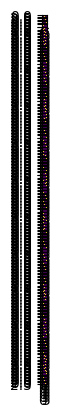

In [27]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(all_layouts.shape[0],1)

for i, ax in enumerate(axes):
    ax.imshow(all_layouts[i])

In [28]:
def split_train_test_balanced(all_layouts, port_dim, train_ratio=0.5):
    """
    Split the layouts into train and test sets with a given ratio, ensuring that each possible 
    initiation position (perm[0]) and choice positions ([perm[1], perm[2]]) are split according to 
    the specified ratio.

    Args:
    all_layouts (numpy.ndarray): The array containing all layouts.
    port_dim (int): The dimension of the one-hot vectors.
    train_ratio (float): The ratio of layouts to include in the training set.

    Returns:
    tuple: Two numpy arrays representing the train and test sets.
    """
    # Initialize lists to store train and test layouts
    train_layouts = []
    test_layouts = []

    # Counters for initiation and choice positions in train and test sets
    count_train_init = {i: 0 for i in range(port_dim)}
    count_train_choice = {i: 0 for i in range(port_dim)}
    count_test_init = {i: 0 for i in range(port_dim)}
    count_test_choice = {i: 0 for i in range(port_dim)}

    # Shuffle layouts
    np.random.shuffle(all_layouts)

    # Function to check if adding to train/test set is possible
    def can_add(count_dict, position, max_count):
        return count_dict[position] < max_count

    # Iterate over layouts to assign them to train/test sets
    for layout in all_layouts:
        init_pos = np.argmax(layout[0])
        choice_pos = [np.argmax(layout[1]), np.argmax(layout[2])]

        # Calculate max allowed counts for train and test sets
        max_train_count = train_ratio * len(all_layouts) // port_dim
        max_test_count = (1 - train_ratio) * len(all_layouts) // port_dim

        # Try adding to train set
        if (can_add(count_train_init, init_pos, max_train_count) and 
            all(can_add(count_train_choice, pos, max_train_count) for pos in choice_pos)):
            train_layouts.append(layout)
            count_train_init[init_pos] += 1
            for pos in choice_pos:
                count_train_choice[pos] += 1
        # Try adding to test set
        elif (can_add(count_test_init, init_pos, max_test_count) and 
              all(can_add(count_test_choice, pos, max_test_count) for pos in choice_pos)):
            test_layouts.append(layout)
            count_test_init[init_pos] += 1
            for pos in choice_pos:
                count_test_choice[pos] += 1

    return np.array(train_layouts), np.array(test_layouts)

# Splitting the layouts into train and test sets
train_layouts, test_layouts = split_train_test_balanced(all_layouts, port_dim)
train_layouts.shape, test_layouts.shape  # Check the shapes of the train and test sets


((29, 3, 6), (29, 3, 6))

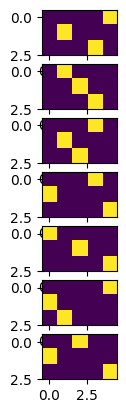

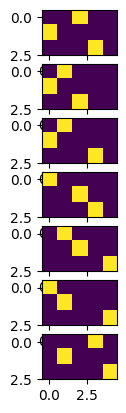

In [24]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(train_layouts.shape[0],1)

for i, ax in enumerate(axes):
    ax.imshow(train_layouts[i])

import matplotlib.pyplot as plt
fig, axes = plt.subplots(test_layouts.shape[0],1)

for i, ax in enumerate(axes):
    ax.imshow(test_layouts[i])

In [30]:
import random

def generate_and_split_permutations(port_dim, train_ratio=0.8):
    """
    Generate all permutations and split them into two sets while ensuring that equivalent
    permutations end up in the same set and respecting the 80:20 distribution ratio.

    Args:
    port_dim (int): The range of numbers to generate permutations from.
    train_ratio (float): The ratio of permutations to include in the training set.

    Returns:
    tuple: Two lists representing the train and test sets.
    """
    # Generate all permutations
    perms = permutations(range(port_dim), 3)

    # Group permutations into entities where (x, y, z) and (x, z, y) are treated as one
    perm_entities = {(x, y, z) for x, y, z in perms}

    # Shuffle entities
    perm_entities = list(perm_entities)
    random.shuffle(perm_entities)

    # Initialize train and test sets
    train_set = []
    test_set = []

    # Counters for initiation and choice ports
    init_port_counter = {i: 0 for i in range(port_dim)}
    choice_port_counter = {frozenset([i, j]): 0 for i in range(port_dim) for j in range(port_dim) if i != j}

    # Split entities into train and test sets
    for entity in perm_entities:
        x, y, z = entity

        # Calculate whether this entity should go into train or test set
        if (init_port_counter[x] < train_ratio * port_dim * (port_dim - 1) and 
            choice_port_counter[frozenset([y, z])] < train_ratio * port_dim * (port_dim - 1) * (port_dim - 2) / 2):
            train_set.extend([entity, (x, z, y)])
            init_port_counter[x] += 2
            choice_port_counter[frozenset([y, z])] += 2
        else:
            test_set.extend([entity, (x, z, y)])

    return train_set, test_set

# Splitting the permutations into train and test sets
port_dim = 5  # Example port dimension
train_set, test_set = generate_and_split_permutations(port_dim)
len(train_set), len(test_set)  # Check the lengths of the train and test sets


(80, 40)

In [54]:
def generate_permutation_sets(port_dim):
    """
    Generate sets of permutations for each initiation port and each pair of choice ports.

    Args:
    port_dim (int): The range of numbers to generate permutations from.

    Returns:
    dict, dict: Two dictionaries containing sets of permutations for initiation ports and choice ports.
    """
    # Generate all permutations
    perms = list(permutations(range(port_dim), 3))

    # Dictionaries for initiation port sets and choice port sets
    # init_port_sets = {i: set() for i in range(port_dim)}
    choice_port_sets = {frozenset([i, j]): set() for i in range(port_dim) for j in range(port_dim) if i != j}

    # Populate the sets
    for perm in perms:
        x, y, z = perm
        # init_port_sets[x].add(perm)
        choice_port_sets[frozenset([y, z])].add(perm)

    return choice_port_sets


In [177]:
print(test[0])
print(init[0])
print(a[0])
print(b[0])
print(test)

[0 3 1]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 1. 0. 0. 0. 0.]
[[0 3 1]
 [4 3 1]
 [0 1 3]
 [2 1 3]
 [4 1 3]
 [2 3 1]
 [3 4 0]
 [1 0 4]
 [1 4 0]
 [2 4 0]
 [2 0 4]
 [3 0 4]]


In [84]:
%load_ext autoreload
%autoreload 2

from curriculum import train_test_split

train, test, all = train_test_split()

print(len(train), len(test))

print(np.unique(train[:,0], return_counts=True))
print(np.unique(test[:,0], return_counts=True))

print(np.unique(train[:,1], return_counts=True))
print(np.unique(test[:,1], return_counts=True))

print(np.unique(train[:,2], return_counts=True))
print(np.unique(test[:,2], return_counts=True))

# print(len(all))# q: how to count instances of each number in a column?
print(all[:20])
# a:

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
378 126
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([42, 42, 42, 42, 42, 42, 42, 42, 42]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([14, 14, 14, 14, 14, 14, 14, 14, 14]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([42, 42, 42, 42, 42, 42, 42, 42, 42]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([14, 14, 14, 14, 14, 14, 14, 14, 14]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([42, 42, 42, 42, 42, 42, 42, 42, 42]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([14, 14, 14, 14, 14, 14, 14, 14, 14]))
[[0 1 2]
 [0 1 3]
 [0 1 4]
 [0 1 5]
 [0 1 6]
 [0 1 7]
 [0 1 8]
 [0 2 1]
 [0 2 3]
 [0 2 4]
 [0 2 5]
 [0 2 6]
 [0 2 7]
 [0 2 8]
 [0 3 1]
 [0 3 2]
 [0 3 4]
 [0 3 5]
 [0 3 6]
 [0 3 7]]


In [81]:
a = np.where(test[:,-1]==4)
b = np.where(test[:,-1]==3)
print(test[a,:])
print(test[b,:])

[[[0 5 4]
  [1 5 4]
  [2 5 4]
  [3 5 4]
  [6 5 4]
  [7 5 4]
  [8 5 4]]]
[[[0 6 3]
  [1 6 3]
  [2 6 3]
  [4 6 3]
  [5 6 3]
  [7 6 3]
  [8 6 3]
  [0 2 3]
  [1 2 3]
  [4 2 3]
  [5 2 3]
  [6 2 3]
  [7 2 3]
  [8 2 3]]]
